# Week 8 - Mariana MacDonald


In [68]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [69]:
import numpy as np
import pandas as pd

import thinkstats2
import thinkplot

In [70]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [71]:
import first

live, firsts, others = first.MakeFrames()

In [72]:
import statsmodels.formula.api as smf


In [73]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

In [74]:
import nsfg

live = live[live.prglngth>30]
resp = nsfg.ReadFemResp()
resp.index = resp.caseid
join = live.join(resp, on='caseid', rsuffix='_r')
join.shape

(8884, 3331)

In [75]:
import patsy

def GoMining(df):
    """Searches for variables that predict birth weight.

    df: DataFrame of pregnancy records

    returns: list of (rsquared, variable name) pairs
    """
    variables = []
    for name in df.columns:
        try:
            if df[name].var() < 1e-7:
                continue

            formula = 'totalwgt_lb ~ agepreg + ' + name
            model = smf.ols(formula, data=df)
            if model.nobs < len(df)/2:
                continue

            results = model.fit()
        except (ValueError, TypeError, patsy.PatsyError) as e:
            continue
        
        variables.append((results.rsquared, name))

    return variables

In [76]:
import re

def ReadVariables():
    """Reads Stata dictionary files for NSFG data.

    returns: DataFrame that maps variables names to descriptions
    """
    vars1 = thinkstats2.ReadStataDct('2002FemPreg.dct').variables
    vars2 = thinkstats2.ReadStataDct('2002FemResp.dct').variables

    all_vars = vars1.append(vars2)
    all_vars.index = all_vars.name
    return all_vars

def MiningReport(variables, n=30):
    """Prints variables with the highest R^2.

    t: list of (R^2, variable name) pairs
    n: number of pairs to print
    """
    all_vars = ReadVariables()

    variables.sort(reverse=True)
    for r2, name in variables[:n]:
        key = re.sub('_r$', '', name)
        try:
            desc = all_vars.loc[key].desc
            if isinstance(desc, pd.Series):
                desc = desc[0]
            print(name, r2, desc)
        except (KeyError, IndexError):
            print(name, r2)

In [77]:
import first
live, firsts, others = first.MakeFrames()
live = live[live.prglngth>30]
live['boy'] = (live.babysex==1).astype(int)

## Exercises start here

** 11.1 - Exercise:** Suppose one of your co-workers is expecting a baby and you are participating in an office pool to predict the date of birth. Assuming that bets are placed during the 30th week of pregnancy, what variables could you use to make the best prediction? You should limit yourself to variables that are known before the birth, and likely to be available to the people in the pool.

In [78]:
import first
live, firsts, others = first.MakeFrames()
live = live[live.prglngth>30]

In [79]:
#To predict the date of birth (or preglngth), I consider these variables 
#important: nbrnaliv which indicates whether the pregnancy yielded multiple
#babies (twins, triplets) which usually arrive earlier than only one baby,
#and if it's the first baby.

live['isFirst'] = live.birthord == 1
model = smf.ols('prglngth ~ isFirst + nbrnaliv > 1', data = live)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prglngth   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     45.89
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.49e-20
Time:                        21:58:05   Log-Likelihood:                -18253.
No. Observations:                8884   AIC:                         3.651e+04
Df Residuals:                    8881   BIC:                         3.653e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               38.8492      0.028   1386.425      0.000      38.794      38.904
isFirst[T.True]          0.1069      0.040      2.662      0.008       0.028       0.186
nbrnaliv > 1[T.True]    -1.4922      0.165     -9.067      0.000      -1.815      -1.170
==============================================================================
Omnibus:                     1575.089   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6117.494
Skew:                          -0.845   Prob(JB):                         0.00
Kurtosis:                       6.698   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

** 11.3 - Exercise: If the quantity you want to predict is a count, you can use Poisson regression, which is implemented in StatsModels with a function called `poisson`. It works the same way as `ols` and `logit`. As an exercise, let’s use it to predict how many children a woman has born; in the NSFG dataset, this variable is called `numbabes`.

Suppose you meet a woman who is 35 years old, black, and a college graduate whose annual household income exceeds $75,000. How many children would you predict she has born?

In [80]:
# create a column age2 that contains the squares of the ages

join['age2'] = join.age_r**2

#totincr is encoded numerically from 1-13, with each increment representing
#about $5000 in annual income.

model = smf.poisson('numbabes ~ age_r + C(race) + totincr + educat', data = join)
results = model.fit()
results.summary() 

Optimization terminated successfully.
         Current function value: 1.687055
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               numbabes   No. Observations:                 8884
Model:                        Poisson   Df Residuals:                     8878
Method:                           MLE   Df Model:                            5
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                 0.03109
Time:                        21:58:08   Log-Likelihood:                -14988.
converged:                       True   LL-Null:                       -15469.
Covariance Type:            nonrobust   LLR p-value:                1.106e-205
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0842      0.045     23.995      0.000       0.996       1.173
C(race)[T.2]    -0.1398      0.015     -9.464      0.000      -0.169      -0.111
C(race)[T.3]    -0.0914      0.025     -3.717      0.000      -0.140      -0.043
age_r            0.0208      0.001     20.474      0.000       0.019       0.023
totincr         -0.0179      0.002     -9.442      0.000      -0.022      -0.014
educat          -0.0443      0.003    -15.139      0.000      -0.050      -0.039
================================================================================
"""

Now we can predict the number of children for a woman who is 35 years old, black, and a college
graduate whose annual household income exceeds $75,000

In [81]:
#considering a woman (age_r = 35), age2 being 35**2, 1 for black race,
#14 for the $75K salary and 16 representing the college graduate), we 
#will predict how many children she has born.


columns = ['age_r', 'age2', 'race', 'totincr','educat']
prediction_df = pd.DataFrame([[35, 35**2, 1, 14, 16]], columns = columns)
results.predict(prediction_df)

0    2.342182
dtype: float64

The result is about 2 children.

** 11.4 - Exercise:** If the quantity you want to predict is categorical, you can use multinomial logistic regression, which is implemented in StatsModels with a function called `mnlogit`. As an exercise, let’s use it to guess whether a woman is married, cohabitating, widowed, divorced, separated, or never married; in the NSFG dataset, marital status is encoded in a variable called `rmarital`.

Suppose you meet a woman who is 25 years old, white, and a high school graduate whose annual household income is about $45,000. What is the probability that she is married, cohabitating, etc?

In [82]:
#I used the rmarital as dependent variable  and the explanatory variables
#on the right (age_r, race, income and education).

model = smf.mnlogit('rmarital ~ age_r + C(race) + totincr + educat', data = join)
results = model.fit()
results.summary() 

Optimization terminated successfully.
         Current function value: 1.087603
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               rmarital   No. Observations:                 8884
Model:                        MNLogit   Df Residuals:                     8854
Method:                           MLE   Df Model:                           25
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.1655
Time:                        21:58:14   Log-Likelihood:                -9662.3
converged:                       True   LL-Null:                       -11579.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
  rmarital=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.4532      0.279     15.977      0.000       3.907       5.000
C(race)[T.2]    -0.9219      0.089    -10.409      0.000      -1.095      -0.748
C(race)[T.3]    -0.6334      0.136     -4.674      0.000      -0.899      -0.368
age_r           -0.0570      0.006     -9.754      0.000      -0.068      -0.046
totincr         -0.1302      0.012    -11.298      0.000      -0.153      -0.108
educat          -0.2051      0.019    -11.017      0.000      -0.242      -0.169
--------------------------------------------------------------------------------
  rmarital=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.5432      0.916     -4.960      0.000      -6.338      -2.748
C(race)[T.2]    -0.4405      0.236     -1.865      0.062      -0.904       0.023
C(race)[T.3]     0.0329      0.335      0.098      0.922      -0.623       0.689
age_r            0.1301      0.019      6.833      0.000       0.093       0.167
totincr         -0.3251      0.032    -10.182      0.000      -0.388      -0.263
educat          -0.1010      0.048     -2.100      0.036      -0.195      -0.007
--------------------------------------------------------------------------------
  rmarital=4       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.6485      0.302     -8.783      0.000      -3.239      -2.057
C(race)[T.2]    -0.3188      0.093     -3.417      0.001      -0.502      -0.136
C(race)[T.3]    -0.7664      0.171     -4.485      0.000      -1.101      -0.431
age_r            0.0641      0.007      9.817      0.000       0.051       0.077
totincr         -0.2270      0.012    -19.588      0.000      -0.250      -0.204
educat           0.0673      0.017      4.036      0.000       0.035       0.100
--------------------------------------------------------------------------------
  rmarital=5       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8231      0.345      2.385      0.017       0.147       1.500
C(race)[T.2]    -1.0491      0.104    -10.125      0.000      -1.252      -0.846
C(race)[T.3]    -0.5644      0.156     -3.624      0.000      -0.870      -0.259
age_r            0.0063      0.007      0.872      0.383      -0.008       0.020
totincr         -0.2923      0.015    -20.149      0.000      -0.321      -0.264
educat          -0.0136      0.021     -0.639      0.523      -0.056       0.028
--------------------------------------------------------------------------------
  rmarital=6       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.2370      0.275     22.654      0.000       5.697       6.777
C

Make a prediction for a woman who is 25 years old, white, and a high
school graduate whose annual household income is about $45,000.

In [83]:
#for the age, 25 , race 2 for white, income 11 and 12 for 
#high school graduate.
columns = ['age_r', 'age2', 'race', 'totincr', 'educat']
new = pd.DataFrame([[25, 25**2, 2, 11, 12]], columns=columns)
results.predict(new)

,0,1,2,3,4,5
0,0.748384,0.125474,0.001103,0.035295,0.023813,0.065931


Currently Married - about 75% chance // Not married but living with opp sext partner - 13% // Widowed - 0.1% // Divorced - 3.5% // Separated - 2.4% //  never been married.- 6.66%

rmarital
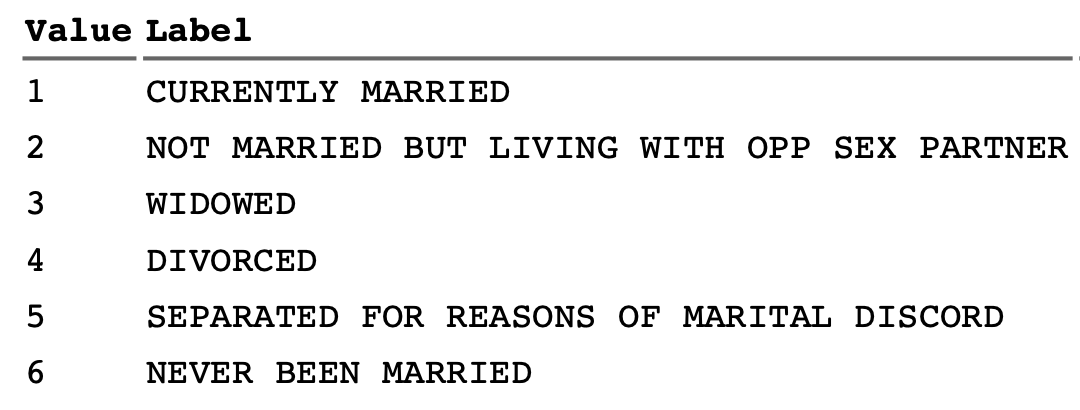

EDUCAT
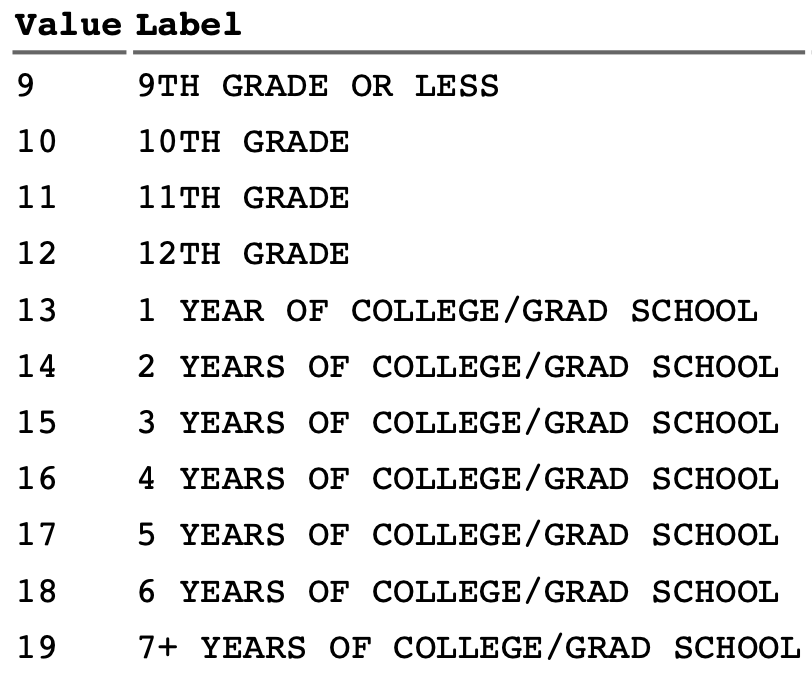

RACE
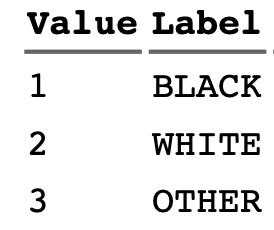